In [8]:
import jax
import equinox as eqx
import equinox.nn as nn
import jax.numpy as jnp


# class ResBlock(eqx.Module):
#     conv1: nn.Conv1d
#     conv2: nn.Conv1d

#     def __init__(self, channel_size, key=None):
#         key1, key2 = jax.random.split(key)

#         self.conv1 = nn.Conv1d(channel_size, channel_size, 3, padding="SAME", key=key1)
#         self.conv2 = nn.Conv1d(channel_size, channel_size, 1, padding="SAME", key=key2)

#     def __call__(self, x):
#         y = self.conv1(x)
#         y = jax.nn.relu(y)
#         y = self.conv2(y)
#         return jax.nn.relu(y) + x


class Encoder(eqx.Module):
    conv1: nn.Conv1d
    conv2: nn.Conv1d
    conv3: nn.Conv1d
    conv4: nn.Conv1d

    def __init__(self, in_channels, hidden_channels, latent_channels, key):
        key1, key2, key3, key4, key5 = jax.random.split(key, 5)

        self.conv1 = nn.Conv1d(
            in_channels,
            hidden_channels,
            kernel_size=4,
            stride=2,
            padding="SAME",
            key=key1,
        )
        self.conv2 = nn.Conv1d(
            hidden_channels,
            hidden_channels,
            kernel_size=4,
            stride=2,
            padding="SAME",
            key=key2,
        )
        self.conv3 = nn.Conv1d(
            hidden_channels,
            hidden_channels,
            kernel_size=4,
            stride=2,
            padding="SAME",
            key=key3,
        )
        self.conv4 = nn.Conv1d(
            hidden_channels, latent_channels, kernel_size=1, key=key4
        )
        # self.res1 = ResBlock(hidden_channels, key=key4)
        # self.res2 = ResBlock(hidden_channels, key=key5)

    def __call__(self, x):
        y = self.conv1(x)
        y = jax.nn.relu(y)
        y = self.conv2(y)
        y = jax.nn.relu(y)
        y = self.conv3(y)
        y = jax.nn.relu(y)
        y = self.conv4(y)

        return y


class Decoder(eqx.Module):
    conv1: nn.ConvTranspose1d
    conv2: nn.ConvTranspose1d
    conv3: nn.ConvTranspose1d
    conv4: nn.ConvTranspose1d

    def __init__(self, in_channels, hidden_channels, latent_channels, key):
        key1, key2, key3, key4, key5 = jax.random.split(key, 5)

        self.conv1 = nn.ConvTranspose1d(
            latent_channels,
            hidden_channels,
            kernel_size=4,
            stride=2,
            padding="SAME",
            key=key1,
        )
        self.conv2 = nn.ConvTranspose1d(
            hidden_channels,
            hidden_channels,
            kernel_size=4,
            stride=2,
            padding="SAME",
            key=key2,
        )
        self.conv3 = nn.ConvTranspose1d(
            hidden_channels,
            hidden_channels,
            kernel_size=4,
            stride=2,
            padding="SAME",
            key=key3,
        )
        self.conv4 = nn.ConvTranspose1d(
            hidden_channels, in_channels, kernel_size=1, key=key4
        )
        # self.res1 = ResBlock(hidden_channels, key=key4)
        # self.res2 = ResBlock(hidden_channels, key=key5)

    def __call__(self, x):
        y = self.conv1(x)
        y = jax.nn.relu(y)
        y = self.conv2(y)
        y = jax.nn.relu(y)
        y = self.conv3(y)
        y = jax.nn.relu(y)
        y = self.conv4(y)

        return y


Codeword = jax.Array
Indices = jax.Array


class FSQ(eqx.Module):
    """Quantizer, taken from https://github.com/google-research/google-research/blob/master/fsq/fsq.ipynb"""

    _levels: list[int]
    _levels_np: jax.Array
    _eps: float
    _basis: jax.Array
    _implicit_codebook: jax.Array

    def __init__(self, levels: list[int], eps: float = 1e-3):
        self._levels = levels
        self._eps = eps
        self._levels_np = jnp.asarray(levels)
        self._basis = jnp.concatenate(
            (jnp.array([1]), jnp.cumprod(self._levels_np[:-1]))
        )

        self._implicit_codebook = self.indexes_to_codes(jnp.arange(self.codebook_size))

    @property
    def num_dimensions(self) -> int:
        """Number of dimensions expected from inputs."""
        return len(self._levels)

    @property
    def codebook_size(self):
        """Size of the codebook."""
        return jnp.prod(jnp.array(self._levels))

    @property
    def codebook(self):
        """Returns the implicit codebook. Shape (prod(levels), num_dimensions)."""
        return self._implicit_codebook

    @eqx.filter_jit
    def round_ste(self, z):
        """Round with straight through gradients."""
        zhat = jnp.round(z)
        return z + jax.lax.stop_gradient(zhat - z)

    @eqx.filter_jit
    def bound(self, z: jax.Array) -> jax.Array:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels_np - 1) * (1 - self._eps) / 2
        offset = jnp.where(self._levels_np % 2 == 1, 0.0, 0.5)
        shift = jnp.tan(offset / half_l)
        return jnp.tanh(z + shift) * half_l - offset

    @eqx.filter_jit
    def __call__(self, z: jax.Array) -> Codeword:
        """Quanitzes z, returns quantized zhat, same shape as z."""
        quantized = self.round_ste(self.bound(z))

        # Renormalize to [-1, 1].
        half_width = self._levels_np // 2
        return quantized / half_width

    def _scale_and_shift(self, zhat_normalized):
        # Scale and shift to range [0, ..., L-1]
        half_width = self._levels_np // 2
        return (zhat_normalized * half_width) + half_width

    def _scale_and_shift_inverse(self, zhat):
        half_width = self._levels_np // 2
        return (zhat - half_width) / half_width

    def codes_to_indexes(self, zhat: Codeword) -> Indices:
        """Converts a `code` to an index in the codebook."""
        assert zhat.shape[-1] == self.num_dimensions
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(axis=-1).astype(jnp.uint32)

    def indexes_to_codes(self, indices: Indices) -> Codeword:
        """Inverse of `indexes_to_codes`."""
        indices = indices[..., jnp.newaxis]
        codes_non_centered = jnp.mod(
            jnp.floor_divide(indices, self._basis), self._levels_np
        )
        return self._scale_and_shift_inverse(codes_non_centered)


class VQVAE(eqx.Module):
    encoder: Encoder
    decoder: Decoder
    quantizer: FSQ

    def __init__(self, in_channels, hidden_channels, latent_channels, levels, key=None):
        key1, key2 = jax.random.split(key)

        self.encoder = Encoder(in_channels, hidden_channels, latent_channels, key1)
        self.decoder = Decoder(in_channels, hidden_channels, latent_channels, key2)
        self.quantizer = FSQ(levels=levels)
        print("✅ Model initialized")

    def __call__(self, x):
        x = jnp.expand_dims(x, 0)
        
        z_e = self.encoder(x)
        z_q = self.quantizer(z_e)
        y = self.decoder(z_q)

        y = jnp.squeeze(y)
        return y

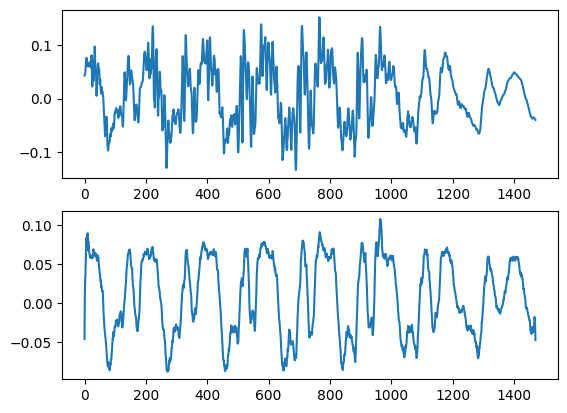

In [ ]:
import optax
from tensorboardX import SummaryWriter
from datasets import load_dataset
import datetime

import jax
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

key1, key2 = jax.random.split(jax.random.key(2), 2)

model = VQVAE(1, 32, 64, [8], key=key1)

optimizer = optax.adam(1e-4)
opt_state = optimizer.init(model)

writer = SummaryWriter(log_dir='./runs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

epochs = 50
batch_size = 1
step = 0

dataset = load_dataset("blabble-io/libritts_r", "clean", streaming=True)

freq = 15
stride = int(22050 / freq)
def cut_up(samples):
    list = []
    for sample in samples["audio"]:
        for i in range(0, (int(len(sample["array"])//stride) -1)):
            list.append(sample["array"][i*stride:i*stride+stride])
    return {"audio": list}

dataset = dataset.map(cut_up, batched=True, remove_columns=['text_normalized', 'text_original', 'speaker_id', 'path', 'chapter_id', 'id'])

dataloader= dataset["train.clean.360"].batch(batch_size=batch_size)
fig, (ax1, ax2) = plt.subplots(2)
fig.show()

@eqx.filter_jit
@eqx.filter_value_and_grad(has_aux=True)
def calculate_losses(model, x):
    y = jax.vmap(model)(x)
    y = y[:, :-2]
    return jnp.mean(jnp.linalg.norm((x - y), ord=2, axis=(0, 1))), y

@eqx.filter_jit
def make_step(model, optimizer, opt_state, x):
    (total_loss, y), grads = (
        calculate_losses(model, x)
    )
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)

    return (
        model,
        opt_state,
        total_loss,
        y
    )

step = 0
for epoch in range(epochs):
    for batch in dataloader:
        input = jax.numpy.array(batch["audio"])
        model, opt_state, total_loss, y = make_step(model, optimizer, opt_state, input)

        # Log codebook updates to TensorBoard
        writer.add_scalar('Loss/Total', total_loss, step)
        if (step // batch_size) % 20 == 0:
            ax1.clear()
            ax2.clear()
            ax1.plot(batch["audio"][0])
            ax2.plot(y[0])
            display(fig)
            clear_output(wait=True)

        step+=1